# LA Times

develop a model to predict post performance for new posts a user may want to create for this account.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pandas as pd
import numpy as np
import zipfile
from pandas.io.json import json_normalize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import AdaBoostRegressor

from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer, BaseSentimentAnalyzer

In [2]:
%%time

with zipfile.ZipFile('posts.json.zip') as myzip:
    with myzip.open('posts.json') as f:
        lines = f.readlines()
        data = [json.loads(line) for line in lines]

CPU times: user 4.81 s, sys: 302 ms, total: 5.11 s
Wall time: 5.12 s


In [3]:
%%time

df = json_normalize(data)

display(df.head())
display(df.shape)

,caption,created_time,description,feed_targeting.reach_estimate,id,insights.post_consumptions.description,insights.post_consumptions.id,insights.post_consumptions.name,insights.post_consumptions.period,insights.post_consumptions.title,...,insights.post_video_views_unique.name,insights.post_video_views_unique.period,insights.post_video_views_unique.title,insights.post_video_views_unique.values,link,link_to_post,message,name,picture,story
0,komonews.com,2015-09-17T20:50:00+0000,About 20 western Virginia high school students...,NaN,114431401958534_940695755998757,Lifetime: The number of clicks anywhere in you...,114431401958534_940695755998757/insights/post_...,post_consumptions,lifetime,Lifetime Post Consumptions,...,post_video_views_unique,lifetime,Lifetime Unique Video Views,[{'value': 0}],http://www.komonews.com/news/national/Students...,http://facebook.com/114431401958534_9406957559...,Do you think the Confederate flag should be ba...,Students suspended for clothing displaying Con...,https://external.xx.fbcdn.net/safe_image.php?d...,NaN
1,NaN,2015-09-17T20:20:01+0000,NaN,NaN,114431401958534_940684872666512,Lifetime: The number of clicks anywhere in you...,114431401958534_940684872666512/insights/post_...,post_consumptions,lifetime,Lifetime Post Consumptions,...,NaN,NaN,NaN,NaN,https://www.facebook.com/KOMONews/photos/a.121...,http://facebook.com/114431401958534_9406848726...,Seattle Seahawks' Russell Wilson answered lots...,Timeline Photos,https://fbcdn-photos-b-a.akamaihd.net/hphotos-...,NaN
2,komonews.com,2015-09-17T19:49:28+0000,Despite September looking like it will break o...,NaN,114431401958534_940684229333243,Lifetime: The number of clicks anywhere in you...,114431401958534_940684229333243/insights/post_...,post_consumptions,lifetime,Lifetime Post Consumptions,...,post_video_views_unique,lifetime,Lifetime Unique Video Views,[{'value': 0}],http://www.komonews.com/weather/blogs/scott/Ne...,http://facebook.com/114431401958534_9406842293...,"It'll be a bummer for snow lovers, but warm-we...","New forecasts still say mild winter, hot summe...",https://external.xx.fbcdn.net/safe_image.php?d...,NaN
3,komonews.com,2015-09-17T19:18:00+0000,Amazon is dangling a $50 tablet computer in it...,NaN,114431401958534_940637569337909,Lifetime: The number of clicks anywhere in you...,114431401958534_940637569337909/insights/post_...,post_consumptions,lifetime,Lifetime Post Consumptions,...,post_video_views_unique,lifetime,Lifetime Unique Video Views,[{'value': 0}],http://www.komonews.com/news/tech/Amazon-dangl...,http://facebook.com/114431401958534_9406375693...,What do you think of Amazon's cheaper tablet?,Amazon dangles $50 tablet computer to hook mor...,https://fbexternal-a.akamaihd.net/safe_image.p...,NaN
4,komonews.com,2015-09-17T18:45:00+0000,Earth's record-breaking heat is sounding an aw...,NaN,114431401958534_940535546014778,Lifetime: The number of clicks anywhere in you...,114431401958534_940535546014778/insights/post_...,post_consumptions,lifetime,Lifetime Post Consumptions,...,post_video_views_unique,lifetime,Lifetime Unique Video Views,[{'value': 0}],http://www.komonews.com/news/national/Earths-r...,http://facebook.com/114431401958534_9405355460...,Meteorologists say 2015 is a near certainty to...,Earth's record streak of record heat keeps on ...,https://external.xx.fbcdn.net/safe_image.php?d...,NaN


(8639, 359)

CPU times: user 28.4 s, sys: 246 ms, total: 28.6 s
Wall time: 28.6 s


In [4]:
insights = df[[col for col in df if col.startswith('insights')]]

In [5]:
pd.DataFrame((df.isna().sum()/df.shape[0]).sort_values(), columns=['Null %']).tail()

,Null %
insights.post_video_complete_views_30s_clicked_to_play.id,0.283945
caption,0.384883
description,0.470656
story,0.935641
feed_targeting.reach_estimate,0.996759


In [6]:
def check_value(x):
    if type(x) == list:
        return x[0]['value']
    else:
        return x

In [7]:
it = insights[[col for col in insights.columns if 'values' in col]]
it.head()

,insights.post_consumptions.values,insights.post_consumptions_by_type.values,insights.post_consumptions_by_type_unique.values,insights.post_consumptions_unique.values,insights.post_engaged_fan.values,insights.post_engaged_users.values,insights.post_fan_reach.values,insights.post_impressions.values,insights.post_impressions_by_paid_non_paid.values,insights.post_impressions_by_paid_non_paid_unique.values,...,insights.post_video_retention_graph_autoplayed.values,insights.post_video_retention_graph_clicked_to_play.values,insights.post_video_views.values,insights.post_video_views_autoplayed.values,insights.post_video_views_clicked_to_play.values,insights.post_video_views_organic.values,insights.post_video_views_organic_unique.values,insights.post_video_views_paid.values,insights.post_video_views_paid_unique.values,insights.post_video_views_unique.values
0,[{'value': 170}],"[{'value': {'other clicks': 151, 'link clicks'...","[{'value': {'other clicks': 91, 'link clicks':...",[{'value': 107}],[{'value': 117}],[{'value': 117}],[{'value': 3566}],[{'value': 4072}],"[{'value': {'paid': 0, 'total': 4072, 'unpaid'...","[{'value': {'paid': 0, 'total': 3583, 'unpaid'...",...,[{'value': {}}],[{'value': {}}],[{'value': 0}],[{'value': 0}],[{'value': 0}],[{'value': 0}],[{'value': 0}],[{'value': 0}],[{'value': 0}],[{'value': 0}]
1,[{'value': 88}],"[{'value': {'other clicks': 61, 'link clicks':...","[{'value': {'other clicks': 49, 'link clicks':...",[{'value': 65}],[{'value': 76}],[{'value': 77}],[{'value': 3560}],[{'value': 5297}],"[{'value': {'paid': 0, 'total': 5297, 'unpaid'...","[{'value': {'paid': 0, 'total': 3618, 'unpaid'...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[{'value': 2169}],"[{'value': {'other clicks': 1162, 'link clicks...","[{'value': {'other clicks': 847, 'link clicks'...",[{'value': 1688}],[{'value': 1799}],[{'value': 2001}],[{'value': 37757}],[{'value': 65538}],"[{'value': {'paid': 0, 'total': 65538, 'unpaid...","[{'value': {'paid': 0, 'total': 43336, 'unpaid...",...,[{'value': {}}],[{'value': {}}],[{'value': 0}],[{'value': 0}],[{'value': 0}],[{'value': 0}],[{'value': 0}],[{'value': 0}],[{'value': 0}],[{'value': 0}]
3,[{'value': 238}],"[{'value': {'other clicks': 95, 'link clicks':...","[{'value': {'other clicks': 84, 'link clicks':...",[{'value': 197}],[{'value': 209}],[{'value': 212}],[{'value': 6036}],[{'value': 9226}],"[{'value': {'paid': 0, 'total': 9226, 'unpaid'...","[{'value': {'paid': 0, 'total': 6263, 'unpaid'...",...,[{'value': {}}],[{'value': {}}],[{'value': 0}],[{'value': 0}],[{'value': 0}],[{'value': 0}],[{'value': 0}],[{'value': 0}],[{'value': 0}],[{'value': 0}]
4,[{'value': 362}],"[{'value': {'other clicks': 241, 'link clicks'...","[{'value': {'other clicks': 161, 'link clicks'...",[{'value': 255}],[{'value': 306}],[{'value': 314}],[{'value': 19474}],[{'value': 32136}],"[{'value': {'paid': 0, 'total': 32136, 'unpaid...","[{'value': {'paid': 0, 'total': 20364, 'unpaid...",...,[{'value': {}}],[{'value': {}}],[{'value': 0}],[{'value': 0}],[{'value': 0}],[{'value': 0}],[{'value': 0}],[{'value': 0}],[{'value': 0}],[{'value': 0}]


# Create Consumption dataframe and join to features

In [8]:
new = it.applymap(lambda x: check_value(x)).select_dtypes(include=[np.number])

# Fill nulls with imputed data
new = new.fillna(method='pad')

In [9]:
new['insights.post_consumptions.values'].describe()

count    8.639000e+03
mean     7.085215e+03
std      5.739073e+04
min      0.000000e+00
25%      8.610000e+02
50%      1.894000e+03
75%      4.789000e+03
max      3.558055e+06
Name: insights.post_consumptions.values, dtype: float64

### Standard Deviation is 57,390
- Log distribution is normal

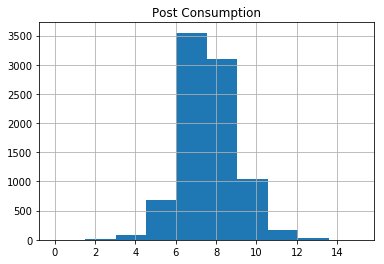

In [10]:
np.log(new['insights.post_consumptions.values']+1).hist()
plt.title('Post Consumption')
plt.show()

## Look at captions
- create feature for komonews

In [11]:
features =pd.get_dummies(df['caption'].fillna('').str.contains(r'komonews.com'), 
                         drop_first=True, prefix='komonnews')

## Look at story

In [12]:
story = df['story'].fillna('').str.lower()

for t, s in [(r'updated', 'story_updated'), 
          (r'added','story_added'), 
          (r'shared', 'story_shared')]:
    
    features[s] = pd.get_dummies(story.str.contains(t), 
                                 prefix=s, 
                                drop_first=True)


## Look at message

In [13]:
# is_upper = []
# for item in df.message.str.split().iteritems():
#     if type(item) == list:
#         is_upper.append(any([x.islower() for x in item[1]]))
#     else:
#         is_upper.append(False)

# features['is_upper'] = is_upper

In [14]:
df['message'][1]

"Seattle Seahawks' Russell Wilson answered lots of questions about hurry-up offense today. What question do you have for the star QB?"

## Run sentiment analysis

In [15]:
%%time

blob = TextBlob(df['message'][0], analyzer=NaiveBayesAnalyzer())
print(blob.sentiment)

Sentiment(classification='pos', p_pos=0.6021601076046352, p_neg=0.3978398923953644)
CPU times: user 3.8 s, sys: 137 ms, total: 3.94 s
Wall time: 3.94 s


## Look at name

Text(0.5, 1.0, 'Timeline Photos in post')

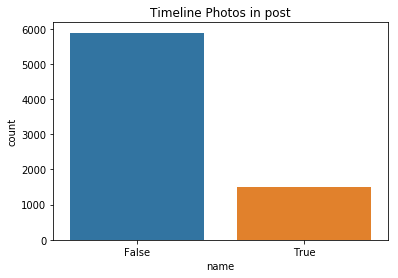

In [16]:
sns.countplot(df['name'].str.contains('Timeline Photos'))
plt.title('Timeline Photos in post')

In [17]:
features['name_timeline_photos'] = pd.get_dummies(
    df['name'].str.contains('Timeline Photos'), 
prefix='timeline_photos',
drop_first=True)

## Look at descriptions

In [18]:
df['description_parsed'] = df['description'].fillna('').str.lower()

## Analyze Polarity and subjectivity

In [19]:
blob = TextBlob(df['description'].fillna('')[0])
blob.sentiment

Sentiment(polarity=0.0987878787878788, subjectivity=0.3315151515151515)

In [20]:
df['description'] = df['description'].fillna('')

In [21]:
pols = df['description'].apply(lambda x: TextBlob(x).sentiment)

In [22]:
features = pd.concat([features, 
 pd.DataFrame([[x[0], x[1]] for x in pols],
            columns=['description_polarity',
                    'description_subjectivity'])], 1)

In [23]:
df['description'].fillna('')[0]

'About 20 western Virginia high school students were suspended Thursday after holding a rally to protest a new policy banning vehicles with Confederate flag symbols from the school parking lot and refusing to take off clothing displaying the symbol.'

## Create features for !, and ?

In [24]:
# features['$_True'] = pd.get_dummies(df['description'].fillna('').str.contains(r'\$'), 
#               prefix='$', drop_first=True)

features['!_True'] = pd.get_dummies(df['description'].fillna('').str.contains(r'\!'), 
              prefix='!', drop_first=True)

features['?_True'] = pd.get_dummies(df['description'].fillna('').str.contains(r'\?'), 
              prefix='?', drop_first=True)

## Parse NLP features to be used later

In [25]:
# remove non alphabetic chars except .
df['description_parsed'] = df['description'].str.replace(r'[^a-z .]', '')

corpus = df['description_parsed'].str.cat().split('.')

# Remove stop words
vectorizer = CountVectorizer(stop_words='english', analyzer='word')
X = vectorizer.fit_transform(corpus)

pd.Series(vectorizer.vocabulary_).sort_values(ascending=False).head()

zoos          14506
zoomed        14505
zookeepers    14504
zookeeper     14503
zoo           14502
dtype: int64

## Parse Time and Create time features

In [26]:
df['created_time'] = pd.to_datetime(df['created_time'])

weekday_name = df['created_time'].dt.weekday_name
month = df['created_time'].dt.month_name()

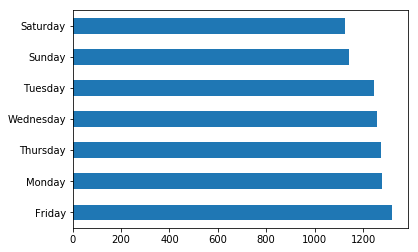

In [27]:
weekday_name.value_counts().plot.barh()
plt.show()

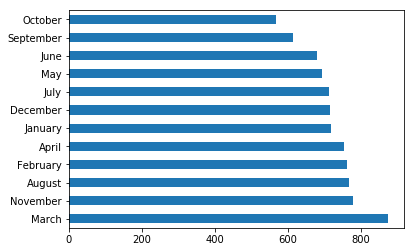

In [28]:
month.value_counts().plot.barh()
plt.show()

## March, Friday, and midnight have the most content

In [29]:
features = pd.concat([features, pd.get_dummies(weekday_name), 
                      pd.get_dummies(month)], 1)

features.head()

,komonnews_True,story_updated,story_added,story_shared,name_timeline_photos,description_polarity,description_subjectivity,!_True,?_True,Friday,...,December,February,January,July,June,March,May,November,October,September
0,1,0,0,0,0,0.098788,0.331515,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,1,0.000000,0.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0.100000,0.612500,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0,0.093750,0.618750,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1,0,0,0,0,-0.233333,0.330556,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Join features with post values

In [30]:
# data = pd.concat([features, new], 1, sort=False)

data = features
data.shape

(8639, 28)

## Develop Random Forest Regression model to predict insights.post_consumptions.values
- Random Forest will be a good choice, because we do not have much feature engineering


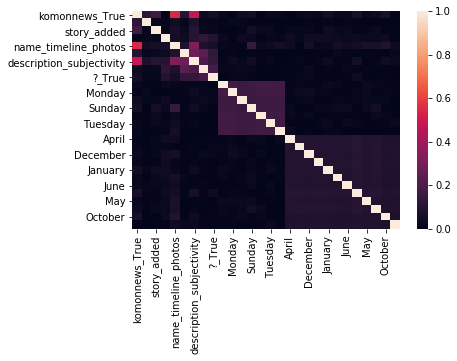

In [31]:
sns.heatmap(data.corr().abs())
plt.show()

## Dropping correlated variables actually makes the model worse

In [33]:
# # Create correlation matrix
# corr_matrix = data.corr().abs()

# # Select upper triangle of correlation matrix
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# # Find index of feature columns with correlation greater than 0.95
# to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# data = data.drop(to_drop, axis=1)

## Create training data

In [34]:
X = data
Y = new['insights.post_consumptions.values']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.33, random_state=42)

## Fit random Forest Regressor

In [36]:
%%time

reg = RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=8).fit(X_train, y_train)

CPU times: user 1.7 s, sys: 34.7 ms, total: 1.74 s
Wall time: 354 ms


## Show 10-fold cross-validation

In [37]:
%%time 

cross_val_score(reg, X, Y, cv=10)

CPU times: user 2.34 s, sys: 958 ms, total: 3.3 s
Wall time: 7.61 s


array([-0.18724074, -0.01471698, -0.00143619, -0.0012173 , -0.04064457,
       -0.13825666, -0.06565801, -0.17585544, -0.02998155, -0.06809313])

## Cross validation shows consistent R-squared values
    So overfitting is not a huge problem for this model

In [38]:
y_pred = reg.predict(X)

mean_absolute_error(Y, y_pred)

8581.664393867291

# The MAE for this solution is 8582, Standard Deviation is 57,300 video consumptions

## TODO with more time
- Tune model hyperparameters; grid-search.
- Parse actions into appropriate data columns
- Utilize NLP features
- Do feature engineering and filtering
- Develop Classification Model?
- test on new data, and evaluate performance